# Uniswap V3 LP — Portfolio Value, Delta & Gamma

Visualise how a concentrated-liquidity LP position's value and greeks change as the underlying price moves.

**Setup**: \$1 MM initial investment in an ETH/USDT 0.3% pool, range ±20% around entry price.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qrisklab.core.univ3_valuation import (
    calc_univ3_value,
    calc_univ3_delta_gamma_analytic,
)

# ── Position parameters ─────────────────────────────────────────────────
S0 = 2_000.0           # entry price (USDT per ETH)
C  = 1_000_000.0       # initial investment in USDT
RANGE_PCT = 0.20       # ±20 % range around entry
Pa = S0 * (1 - RANGE_PCT)   # lower boundary
Pb = S0 * (1 + RANGE_PCT)   # upper boundary

# Price grid: sweep from 50 % below Pa to 50 % above Pb
S_min = Pa * 0.50
S_max = Pb * 1.50
prices = np.linspace(S_min, S_max, 2_000)

# ── Compute value, delta, gamma across the grid ─────────────────────────
values  = np.empty_like(prices)
deltas  = np.empty_like(prices)
gammas  = np.empty_like(prices)

for i, s in enumerate(prices):
    values[i] = calc_univ3_value(s, S0, C, Pa, Pb)
    deltas[i], gammas[i] = calc_univ3_delta_gamma_analytic(s, S0, C, Pa, Pb)

# HODL benchmark: just hold the equivalent ETH amount (C / S0 ETH)
hodl = C / S0 * prices

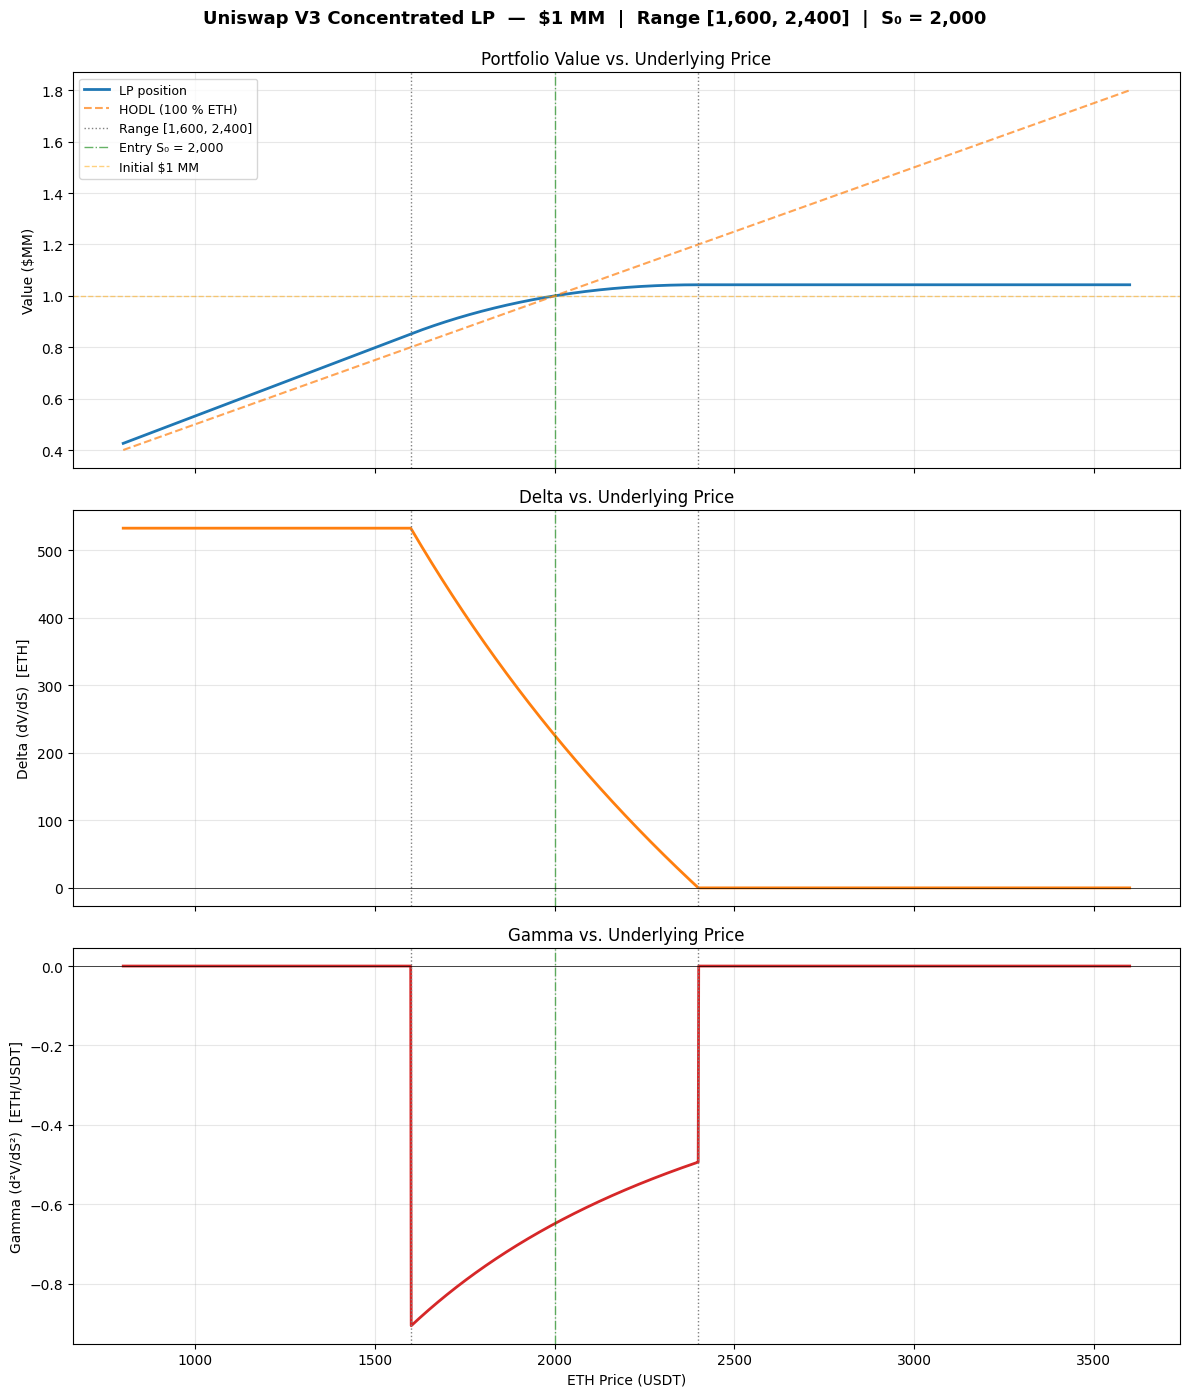

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=True)

# ── 1. Portfolio value ───────────────────────────────────────────────────
ax = axes[0]
ax.plot(prices, values / 1e6, label="LP position", linewidth=2)
ax.plot(prices, hodl / 1e6, label="HODL (100 % ETH)", linewidth=1.5, linestyle="--", alpha=0.7)
ax.axvline(Pa, color="grey", linestyle=":", linewidth=1, label=f"Range [{Pa:,.0f}, {Pb:,.0f}]")
ax.axvline(Pb, color="grey", linestyle=":", linewidth=1)
ax.axvline(S0, color="green", linestyle="-.", linewidth=1, alpha=0.6, label=f"Entry S₀ = {S0:,.0f}")
ax.axhline(C / 1e6, color="orange", linestyle="--", linewidth=1, alpha=0.5, label="Initial $1 MM")
ax.set_ylabel("Value ($MM)")
ax.set_title("Portfolio Value vs. Underlying Price")
ax.legend(loc="upper left", fontsize=9)
ax.grid(True, alpha=0.3)

# ── 2. Delta ─────────────────────────────────────────────────────────────
ax = axes[1]
ax.plot(prices, deltas, color="tab:orange", linewidth=2)
ax.axvline(Pa, color="grey", linestyle=":", linewidth=1)
ax.axvline(Pb, color="grey", linestyle=":", linewidth=1)
ax.axvline(S0, color="green", linestyle="-.", linewidth=1, alpha=0.6)
ax.axhline(0, color="black", linewidth=0.5)
ax.set_ylabel("Delta (dV/dS)  [ETH]")
ax.set_title("Delta vs. Underlying Price")
ax.grid(True, alpha=0.3)

# ── 3. Gamma ─────────────────────────────────────────────────────────────
ax = axes[2]
ax.plot(prices, gammas, color="tab:red", linewidth=2)
ax.axvline(Pa, color="grey", linestyle=":", linewidth=1)
ax.axvline(Pb, color="grey", linestyle=":", linewidth=1)
ax.axvline(S0, color="green", linestyle="-.", linewidth=1, alpha=0.6)
ax.axhline(0, color="black", linewidth=0.5)
ax.set_ylabel("Gamma (d²V/dS²)  [ETH/USDT]")
ax.set_xlabel("ETH Price (USDT)")
ax.set_title("Gamma vs. Underlying Price")
ax.grid(True, alpha=0.3)

fig.suptitle(
    f"Uniswap V3 Concentrated LP  —  $1 MM  |  Range [{Pa:,.0f}, {Pb:,.0f}]  |  S₀ = {S0:,.0f}",
    fontsize=13, fontweight="bold", y=0.995,
)
fig.tight_layout()
plt.show()

## Observations

| Region | Delta | Gamma | Interpretation |
|---|---|---|---|
| Below range (S < Pa) | Constant > 0 | 0 | Position is 100% ETH — linear exposure like a spot holder |
| In range (Pa < S < Pb) | Decreasing > 0 | Negative | As price rises, ETH is sold for USDT — behaves like a short-gamma option writer |
| Above range (S > Pb) | 0 | 0 | Position is 100% USDT — no further price sensitivity |

The **negative gamma** inside the range is the core risk of concentrated liquidity: the position automatically rebalances against you (sells the appreciating asset, buys the depreciating one), which is the source of impermanent loss.

## Impermanent Loss & Sensitivity to Range Width

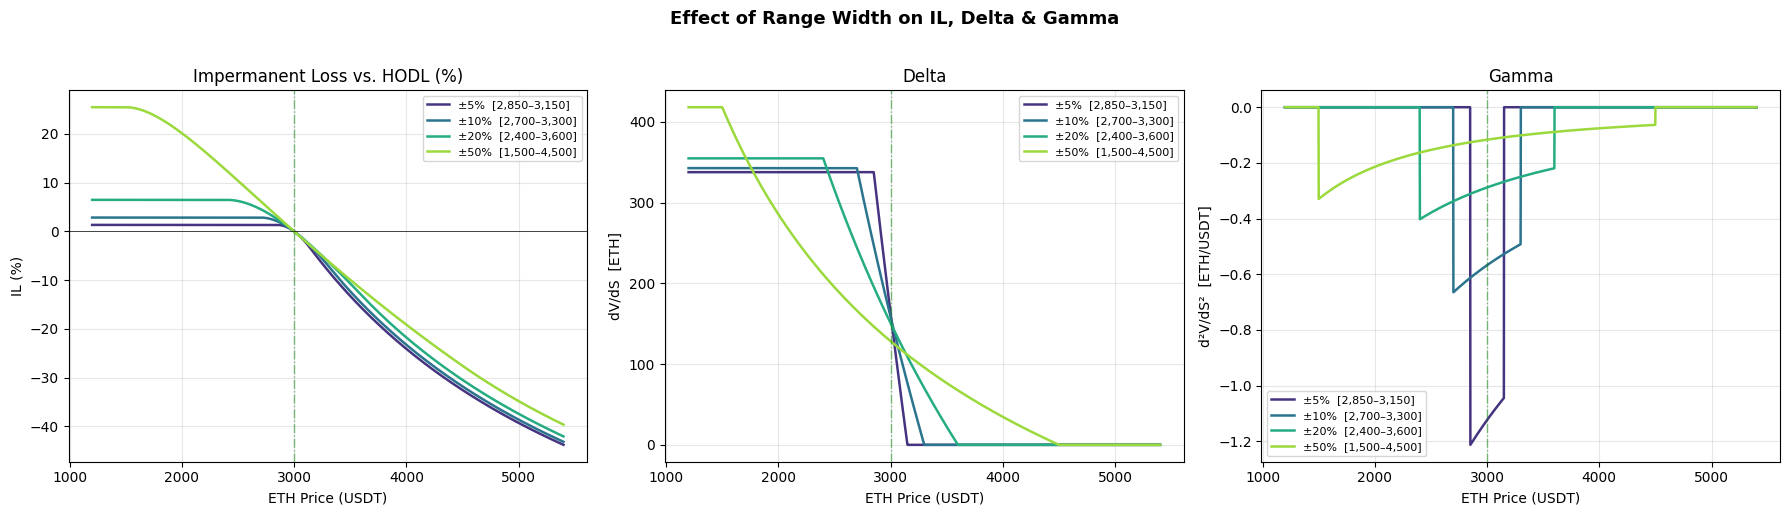

In [3]:
range_widths = [0.05, 0.10, 0.20, 0.50]
colors_rw = plt.cm.viridis(np.linspace(0.15, 0.85, len(range_widths)))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for rw, clr in zip(range_widths, colors_rw):
    pa = S0 * (1 - rw)
    pb = S0 * (1 + rw)
    lbl = f"±{rw*100:.0f}%  [{pa:,.0f}–{pb:,.0f}]"

    vals = np.array([calc_univ3_value(s, S0, C, pa, pb) for s in prices])
    il_pct = (vals / hodl - 1) * 100

    d = np.empty_like(prices)
    g = np.empty_like(prices)
    for i, s in enumerate(prices):
        d[i], g[i] = calc_univ3_delta_gamma_analytic(s, S0, C, pa, pb)

    axes[0].plot(prices, il_pct, color=clr, linewidth=1.8, label=lbl)
    axes[1].plot(prices, d, color=clr, linewidth=1.8, label=lbl)
    axes[2].plot(prices, g, color=clr, linewidth=1.8, label=lbl)

axes[0].set_title("Impermanent Loss vs. HODL (%)")
axes[0].set_ylabel("IL (%)")
axes[0].axhline(0, color="black", linewidth=0.5)

axes[1].set_title("Delta")
axes[1].set_ylabel("dV/dS  [ETH]")

axes[2].set_title("Gamma")
axes[2].set_ylabel("d²V/dS²  [ETH/USDT]")

for ax in axes:
    ax.set_xlabel("ETH Price (USDT)")
    ax.axvline(S0, color="green", linestyle="-.", linewidth=1, alpha=0.5)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

fig.suptitle("Effect of Range Width on IL, Delta & Gamma", fontsize=13, fontweight="bold", y=1.02)
fig.tight_layout()
plt.show()

## Key Metrics at Entry Price

In [4]:
import pandas as pd

rows = []
for rw in [0.05, 0.10, 0.15, 0.20, 0.30, 0.50]:
    pa = S0 * (1 - rw)
    pb = S0 * (1 + rw)
    v0 = calc_univ3_value(S0, S0, C, pa, pb)
    d0, g0 = calc_univ3_delta_gamma_analytic(S0, S0, C, pa, pb)
    # Dollar gamma: how much value changes for a 1% move in price
    dollar_gamma_1pct = 0.5 * g0 * (S0 * 0.01) ** 2
    rows.append({
        "Range": f"±{rw*100:.0f}%",
        "Pa": f"{pa:,.0f}",
        "Pb": f"{pb:,.0f}",
        "Value at S₀": f"${v0:,.0f}",
        "Delta (ETH)": f"{d0:,.4f}",
        "Gamma": f"{g0:.8f}",
        "$ Gamma (1% move)": f"${dollar_gamma_1pct:,.0f}",
    })

pd.DataFrame(rows)

,Range,Pa,Pb,Value at S₀,Delta (ETH),Gamma,$ Gamma (1% move)
0,±5%,"2,850","3,150","$1,000,000",162.5502,-1.12414006,$-506
1,±10%,"2,700","3,300","$1,000,000",158.5265,-0.56773859,$-255
2,±15%,"2,550","3,450","$1,000,000",154.5849,-0.38171823,$-172
3,±20%,"2,400","3,600","$1,000,000",150.7148,-0.28829794,$-130
4,±30%,"2,100","3,900","$1,000,000",143.1479,-0.19405888,$-87
5,±50%,"1,500","4,500","$1,000,000",128.3968,-0.11661618,$-52
